In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
import math
import numpy as np
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from IPython.display import HTML
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib.patches import Rectangle, PathPatch
from tensorflow import keras as K
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import random

# sys.path.append('../../SketchRNN_tf2')
from sketchrnn_ouatai import models, dataset, utils

In [6]:
import random
from PIL import Image
import io
import pandas as pd

In [7]:
!pwd
!ls ../../raw_data/models/

/home/romain/code/Tchook115/ouatai/notebooks
models_sketch_rnn_ant_weights.100.hdf5
models_sketch_rnn_basket_weights.200.hdf5
models_sketch_rnn_bulldozer_weights.100.hdf5
sketch_rnn_cat_weights.78_0.01.hdf5
sketch_rnn_rabbit_weights.100_0.06.hdf5


## dessine moi un objet

In [8]:
best_images = {
    'bulldozer': np.load('/home/romain/code/Tchook115/raw_data/best_bulldozer_100_epochs.npy', allow_pickle=True),
    'rabbit' : np.load('/home/romain/code/Tchook115/raw_data/best_rabbit.npy', allow_pickle=True), 
    'cat' : np.load('/home/romain/code/Tchook115/raw_data/best_cat.npy', allow_pickle=True),
    'ant' : np.load('/home/romain/code/Tchook115/raw_data/best_ant.npy', allow_pickle=True),
    'basket' : np.load('/home/romain/code/Tchook115/raw_data/best_basket.npy', allow_pickle=True)
}
fichiers = {
        'bulldozer': 'models_sketch_rnn_bulldozer_weights.100.hdf5', 
        'cat' : 'sketch_rnn_cat_weights.78_0.01.hdf5',
        'rabbit' : 'sketch_rnn_rabbit_weights.100_0.06.hdf5',
        'ant' : ' models_sketch_rnn_ant_weights.100.hdf5',
        'basket' : 'models_sketch_rnn_basket_weights.200.hdf5'
               }
words = ['bulldozer', 'cat', 'rabbit', 'ant', 'basket']

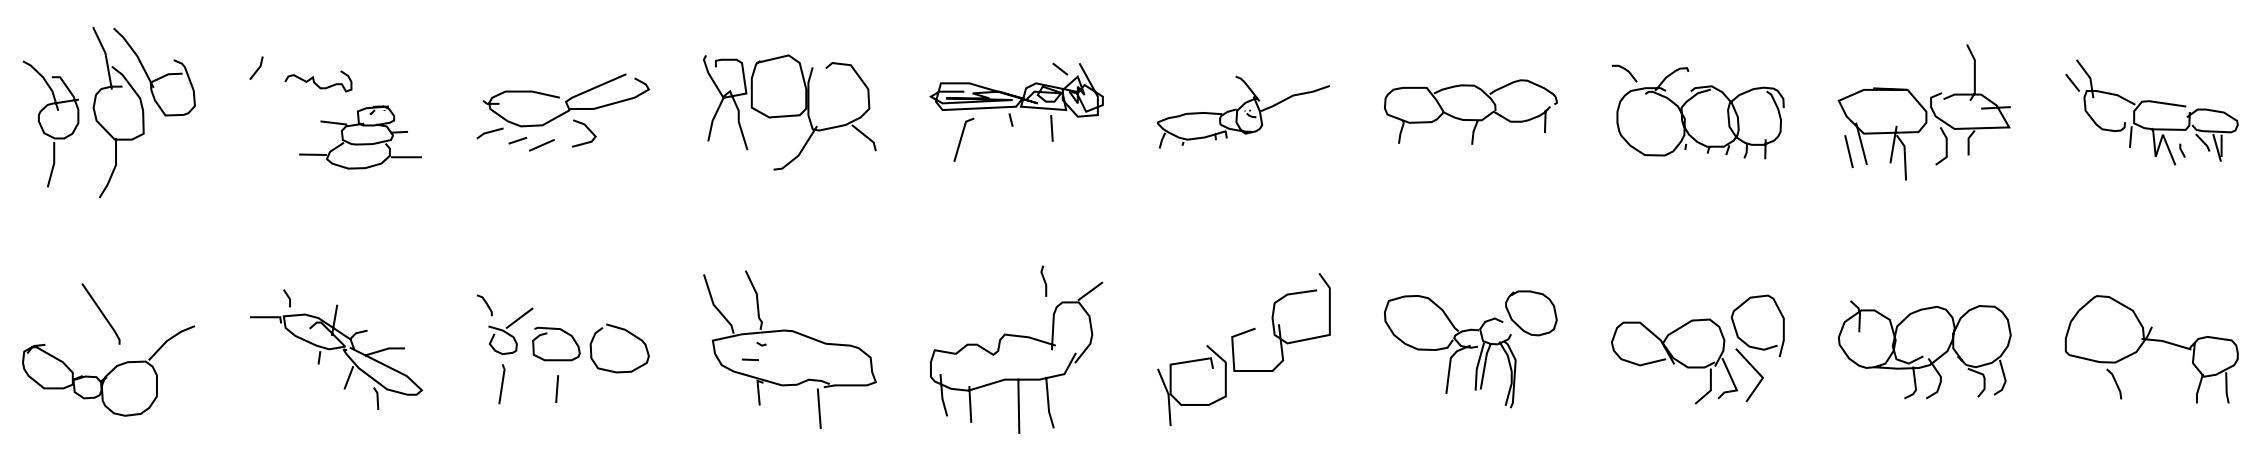

In [9]:
word = 'ant'
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for index, ax in enumerate(axs[0]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index]))
for index, ax in enumerate(axs[1]):
    utils.plot_strokes(ax, utils.to_normal_strokes(best_images[word][index+10]))

In [10]:
def dessine_moi_un(word, temperature = 0.3, color = 'black', zoom = 1, lw = 2 ):
    
    if word not in words:
        return 'essaie un autre mot stp'
    
    #test de variables random
    max_seq_len = best_images[word][0].shape[0]-1
    data_train = [1 for k in range(10000)]
    
    hps = {
        "max_seq_len": max_seq_len,
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 1,
        "recurrent_dropout_prob": 0.1,
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }
    
    # load model
    sketchrnn = models.SketchRNN(hps)
    initial_epoch, initial_loss = 100, 0.06
    
    checkpoint = os.path.join('../../raw_data/models/', fichiers[word])
    sketchrnn.load_weights(checkpoint)
    
    # building image 
    best_pic = random.choice(best_images[word])
    d = np.expand_dims(best_pic,0)
    z = sketchrnn.models['encoder'].predict(d[:,1:])[0]
    strokes = sketchrnn.sample(z=z, temperature=temperature)
    
    final_object = utils.to_normal_strokes(strokes)
    figheight = 3*zoom
    figwidth = 3*zoom
    figsize = (figheight,figwidth)
    fig, ax = plt.subplots(figsize=figsize)
    utils.plot_strokes(ax, final_object, ec = color, lw =lw)
    
    # figure to PIL image
    buf = io.BytesIO()
    fig.savefig(buf, format='png',pad_inches=0,transparent=True)
    buf.seek(0)
    image = Image.open(buf)
    image = image.copy()
    buf.close()
    return image

2021-09-07 13:32:20.092257: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-09-07 13:32:21.673876: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-09-07 13:32:21.674053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Ti Laptop GPU computeCapability: 8.6
coreClock: 1.485GHz coreCount: 20 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
2021-09-07 13:32:21.674124: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-09-07 13:32:21.706846: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-09-07 13:32:21.706921: I tensorflow/

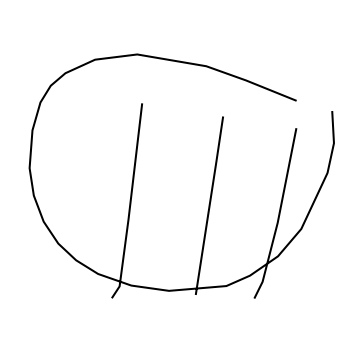

In [11]:
image = dessine_moi_un('basket')

In [12]:
type(image)

PIL.Image.Image

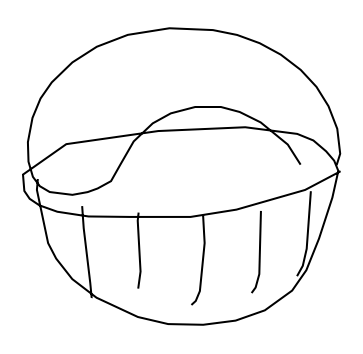

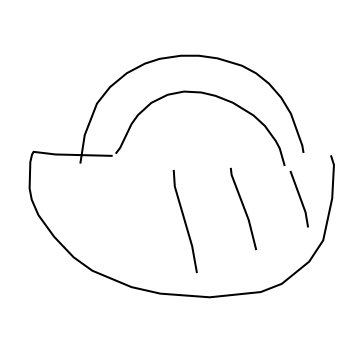

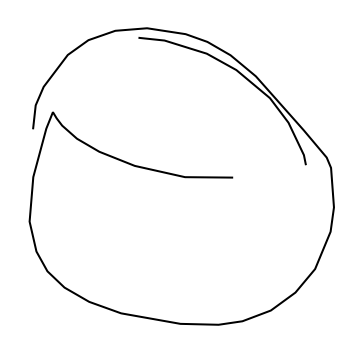

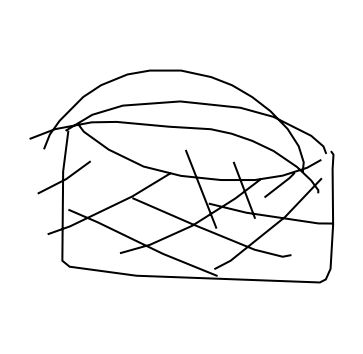

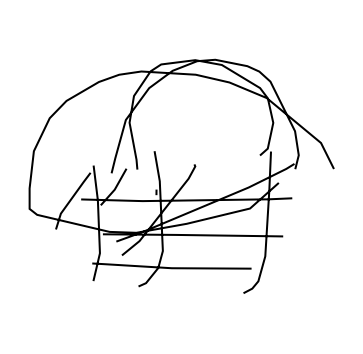

In [13]:
for k in range(5):
    dessine_moi_un('basket')

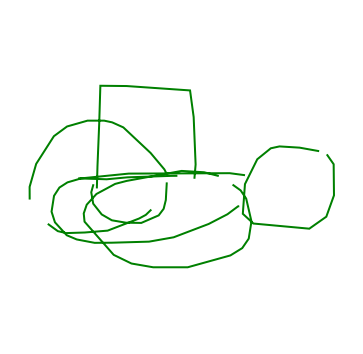

In [14]:
bulldozer = dessine_moi_un('bulldozer', color = 'green', zoom = 1)

In [15]:
type(bulldozer)

PIL.Image.Image

## la scene

In [16]:
scene_size = (2_000, 1_000)

In [17]:
def construis_la_scene(list_objects, scene_size = scene_size):
    '''
    list_objects = [[img_obj1, position_obj1], ...]
    '''
    scene = Image.new('RGBA', scene_size)
    for obj in list_objects:
        scene.paste(obj[0], obj[1])
        #scene = Image.alpha_composite(scene, obj[0])
    return scene

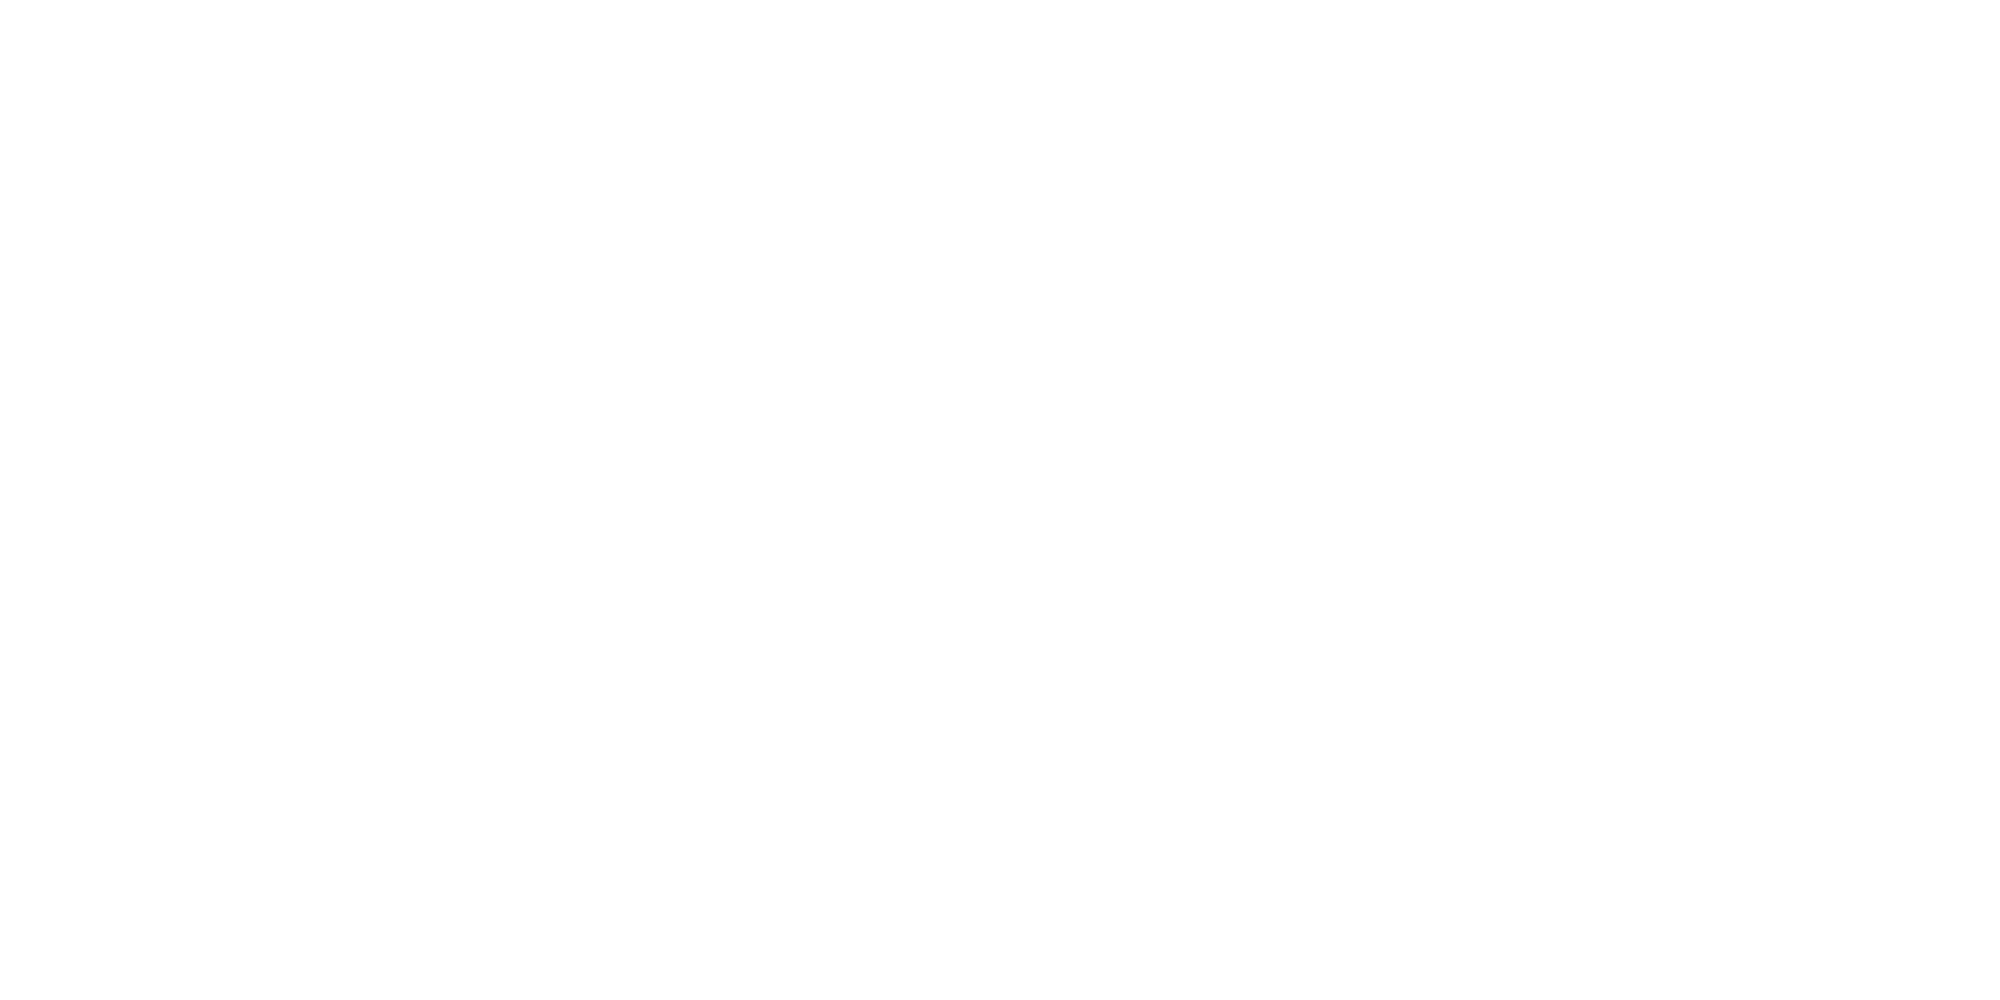

In [18]:
construis_la_scene([])

In [36]:
df = pd.DataFrame(np.array([['cat', 'blue', 'small', 2, 'centre', 'middle'],
                             ['bulldozer', 'orange', 'medium', 1, 'bottom', 'right'], 
                             ['rabbit', 'brown', 'small', 1, 'top', 'left'],
                            ]),
                   columns=['category', 'color', 'size', 'num', 'vertical_position', 'horizontal_position'])
df

,category,color,size,num,vertical_position,horizontal_position
0,cat,blue,small,2,centre,middle
1,bulldozer,orange,medium,1,bottom,right
2,rabbit,brown,small,1,top,left


In [32]:
from PIL import ImageDraw

In [33]:
def df_to_calque(df, scene_size = scene_size):
    list_objects = []
    list_position = []
    vertical_positions = {
        'top' : 0,
        'centre' : int(scene_size[1]/3),
        'bottom' : int(2*scene_size[1]/3)
    }
    horizontal_positions = {
        'left' : 0,
        'middle' : int(scene_size[0]/3),
        'right' : int(2*scene_size[0]/3)
    }
    sizes = {
        'small' : 1/2,
        'medium' : 1,
        'big' : 2
    }
    for index, row in df.iterrows():
        print(f'{index},{row}')
        print
        for n in range(int(row['num'])):            
            category = row['category']
            color = row['color']
            size = sizes[row['size']]
            image = dessine_moi_un(category, color = color, zoom = size)
            imgwidth, imgheight = image.size
            #position
            starthoriz = horizontal_positions[row['horizontal_position']]
            stophoriz = starthoriz + (horizontal_positions['middle'] - imgwidth)
            startvert = vertical_positions[row['vertical_position']]
            stopvert = startvert + (vertical_positions['centre'] - imgheight)
            hor = random.randint(starthoriz,stophoriz)
            vert = random.randint(startvert,stopvert)
            
            list_objects.append([image, (hor, vert)])
    calque = construis_la_scene(list_objects, scene_size)
    #Les traits noirs
    draw = ImageDraw.Draw(calque)
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['centre']), fill="black")
    for h in range(scene_size[0]):
        draw.point((h,vertical_positions['bottom']), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['middle'], v), fill="black")
    for v in range(scene_size[1]):
        draw.point((horizontal_positions['right'], v), fill="black")
    return calque # + coord, size

0,category                  cat
color                    blue
size                    small
num                         2
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
1,category               bulldozer
color                     orange
size                      medium
num                            1
vertical_position         bottom
horizontal_position        right
Name: 1, dtype: object
2,category               rabbit
color                   brown
size                    small
num                         1
vertical_position         top
horizontal_position      left
Name: 2, dtype: object
CPU times: user 8.72 s, sys: 534 ms, total: 9.26 s
Wall time: 6.48 s


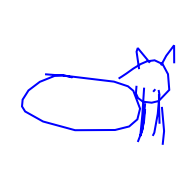

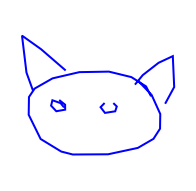

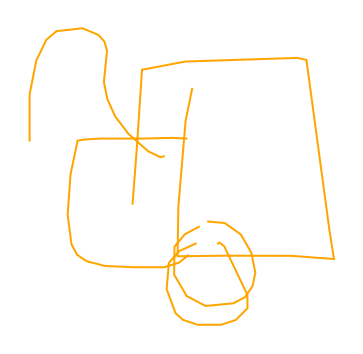

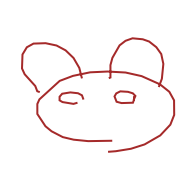

In [37]:
%%time
scene = df_to_calque(df)

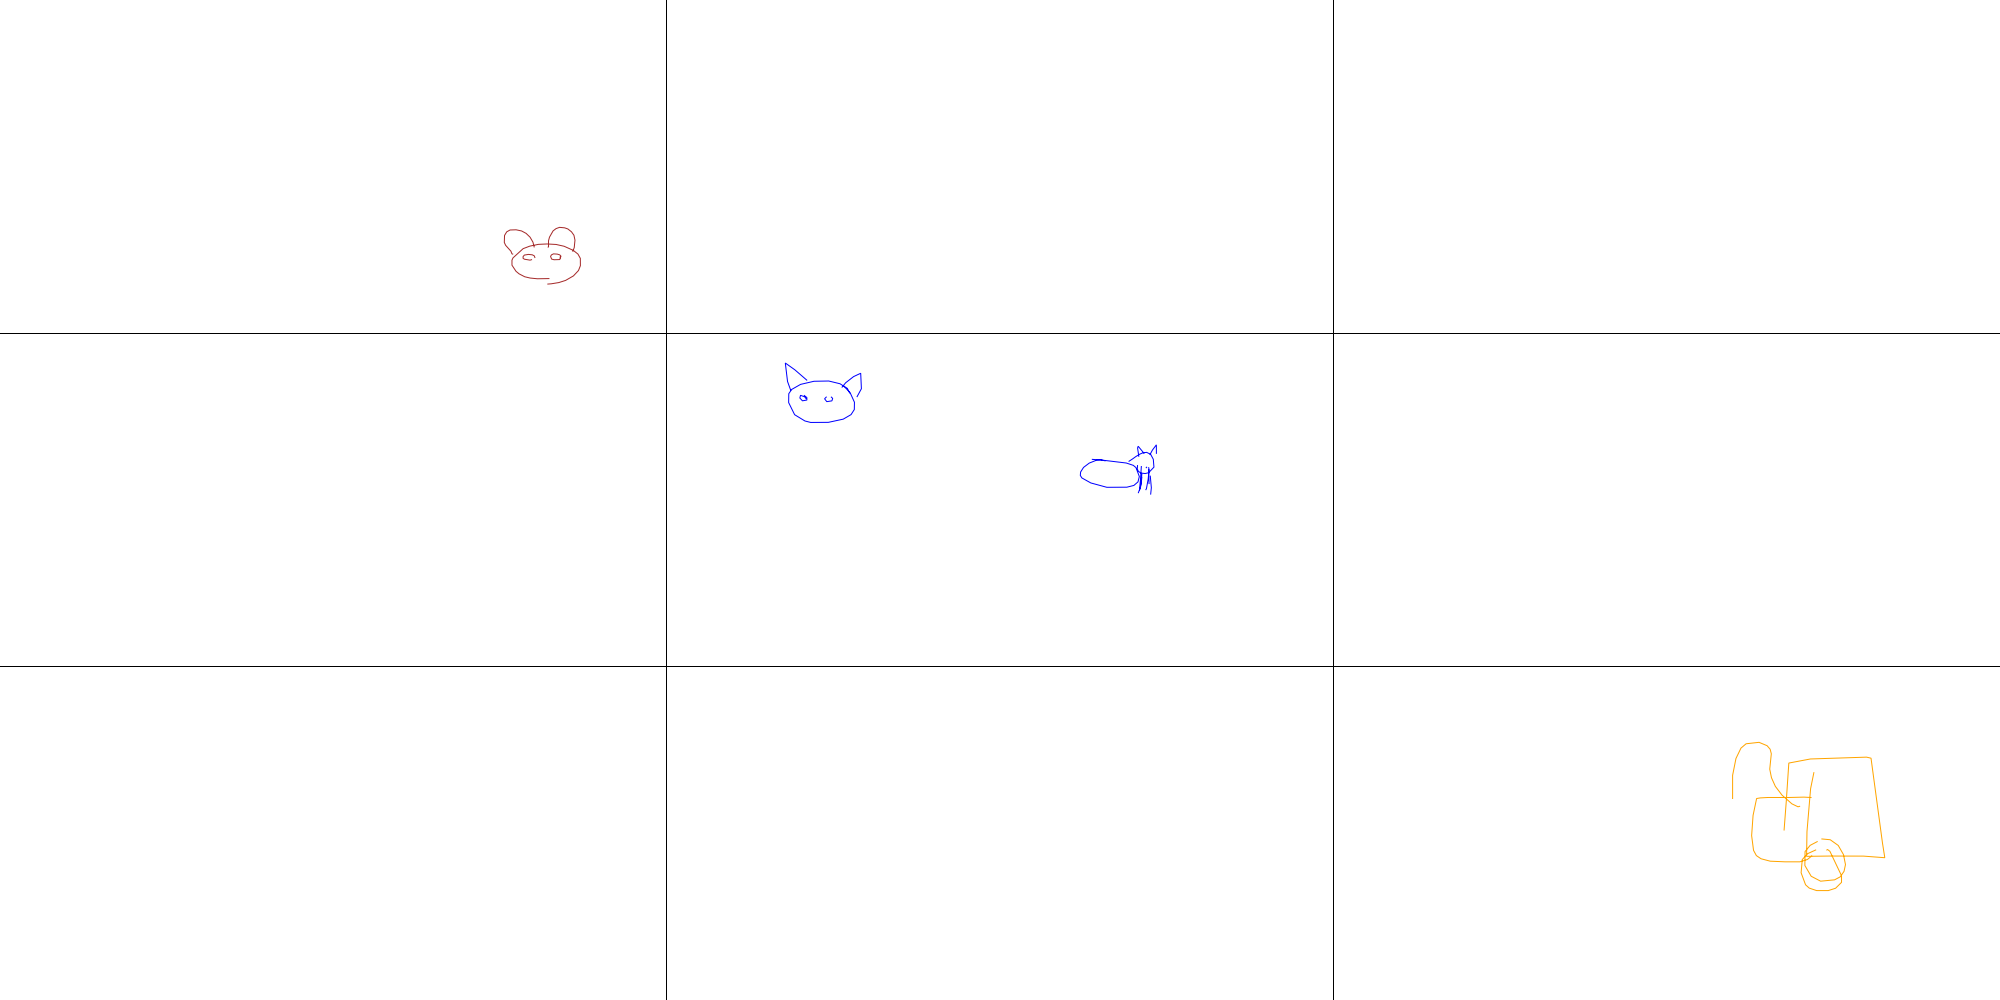

In [38]:
scene

0,category                  cat
color                    blue
size                    small
num                         2
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
1,category               bulldozer
color                     orange
size                      medium
num                            1
vertical_position         bottom
horizontal_position        right
Name: 1, dtype: object
2,category               rabbit
color                   brown
size                    small
num                         1
vertical_position         top
horizontal_position      left
Name: 2, dtype: object
0,category                  cat
color                    blue
size                    small
num                         2
vertical_position      centre
horizontal_position    middle
Name: 0, dtype: object
1,category               bulldozer
color                     orange
size                      medium
num                            1
vertical_position         bo

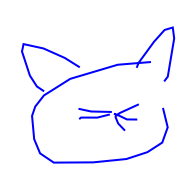

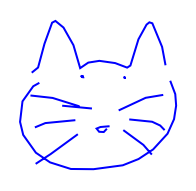

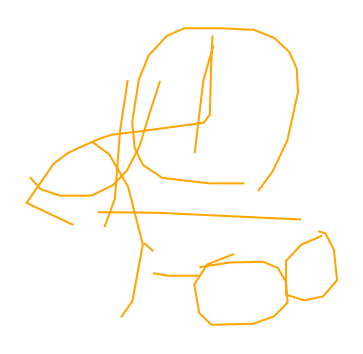

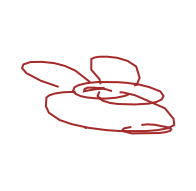

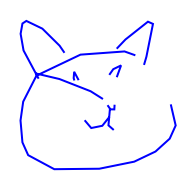

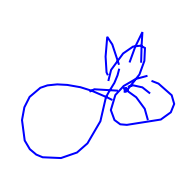

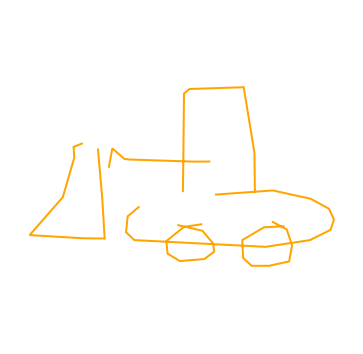

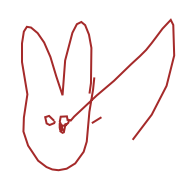

In [39]:
scene1 = df_to_calque(df)
scene2 = df_to_calque(df)

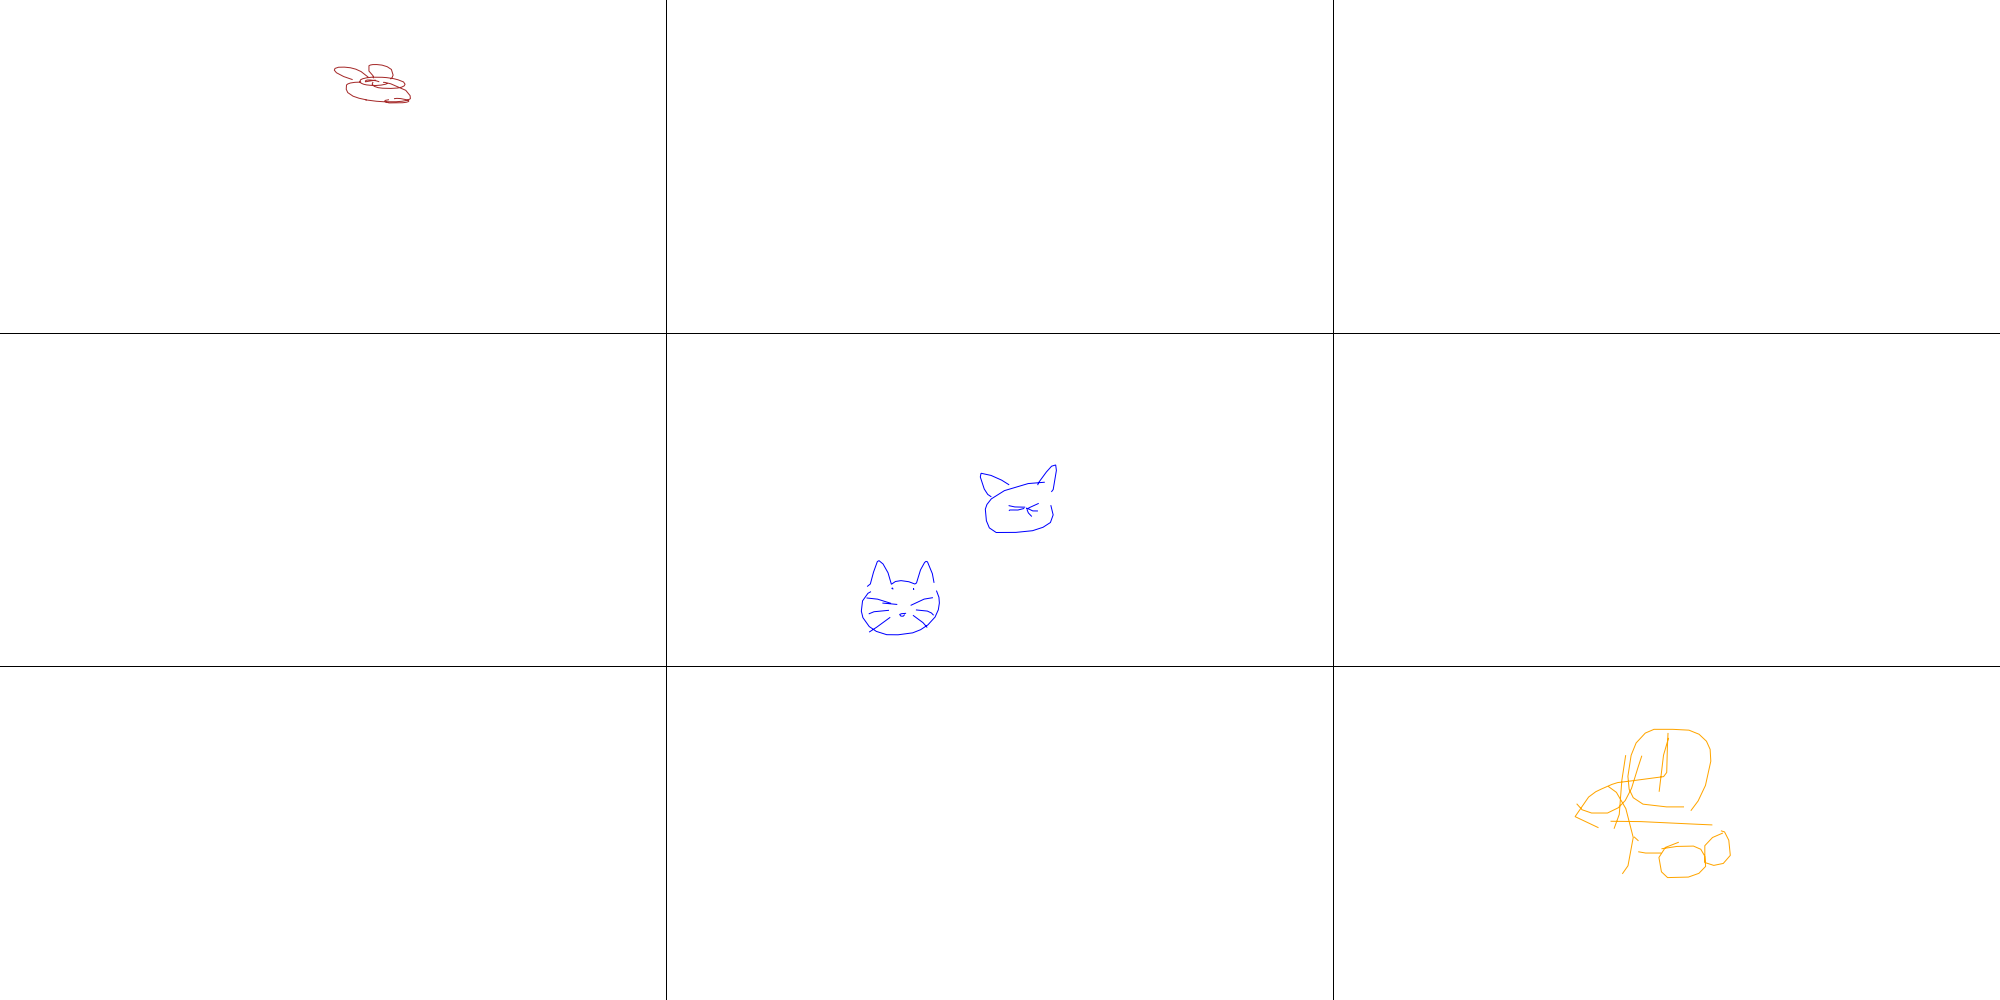

In [40]:
scene1

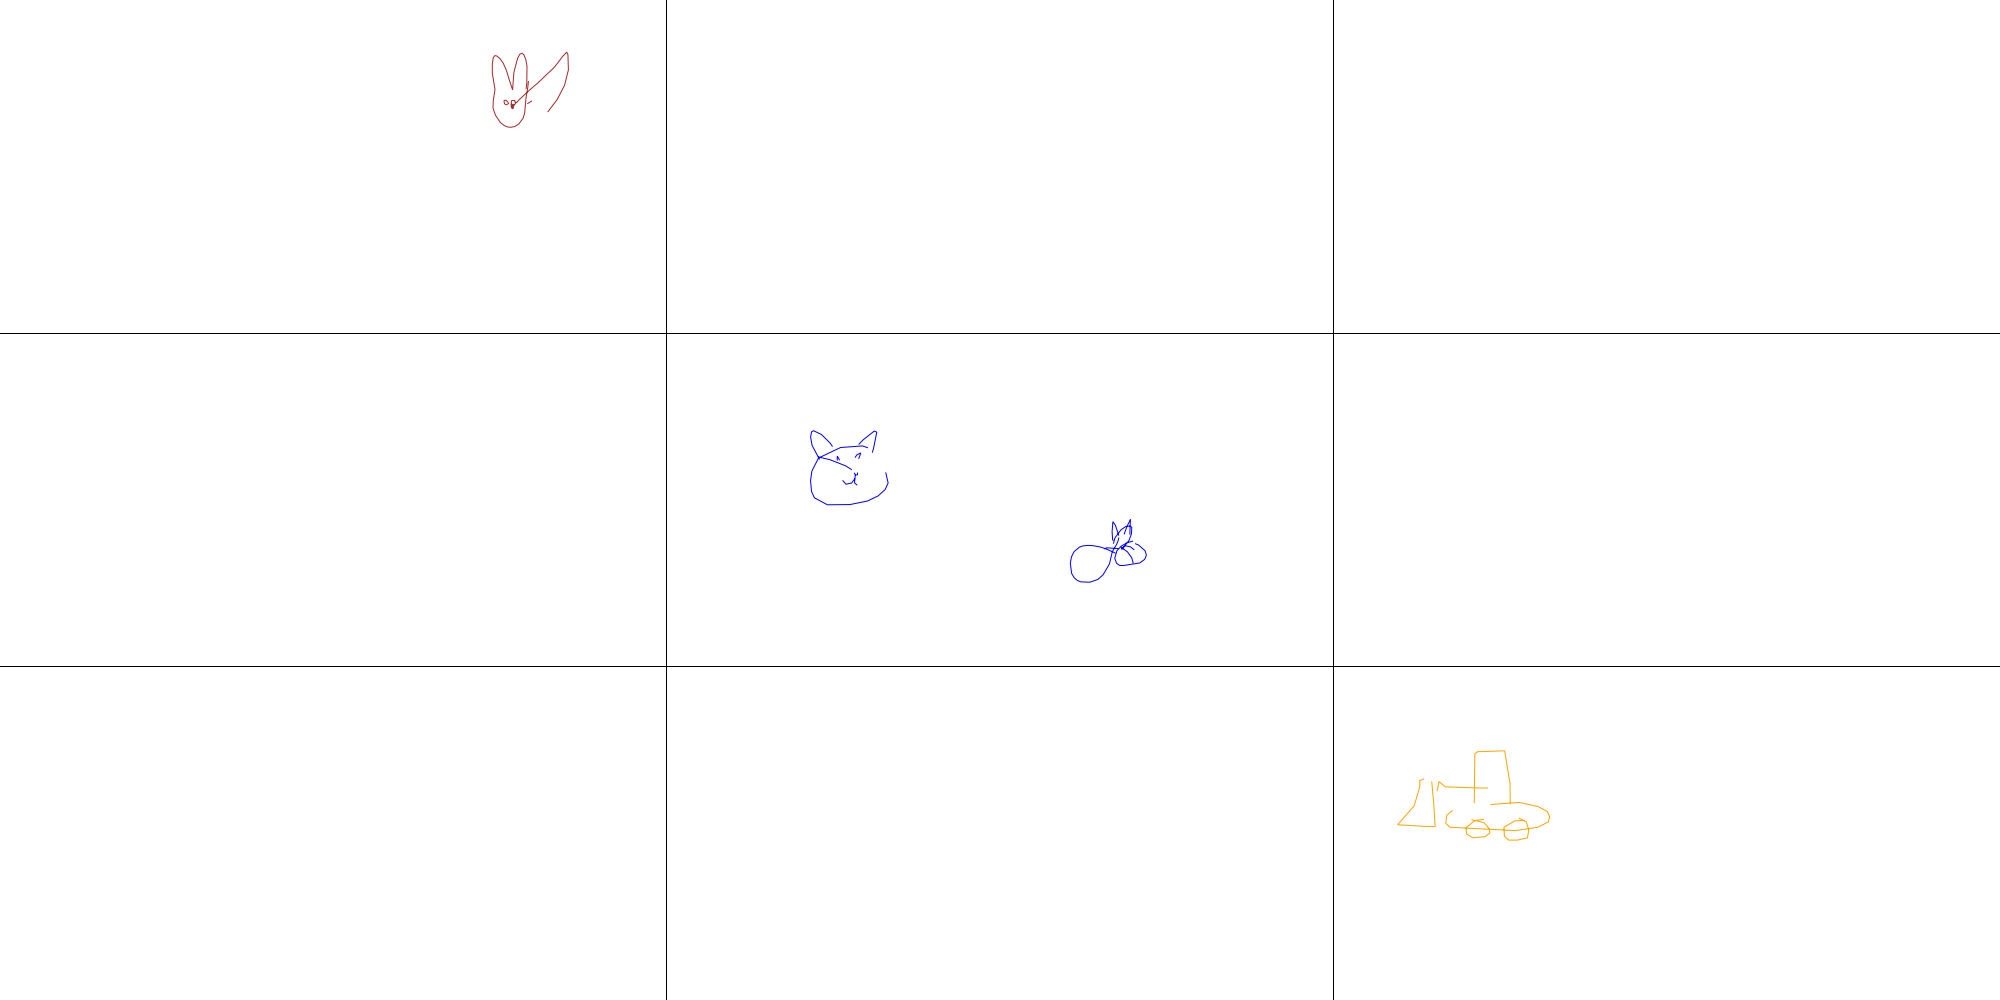

In [41]:
scene2

In [42]:
final2 = Image.new("RGBA", scene1.size)
final2 = Image.alpha_composite(final2, scene1)
final2 = Image.alpha_composite(final2, scene2)